
## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability


In [5]:
# import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# Setting the seed to assure to get the same answers on quizzes
random.seed(42)

Read  the dataset and take a look at the top few rows

In [6]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


##### Assess the dataset

In [7]:
df.shape

(294478, 5)

In [8]:
df.user_id.nunique()

290584

The proportion of users converted.

In [9]:
df[df.converted==1].user_id.nunique() / df.user_id.nunique()

0.12104245244060237

The number of times the `new_page` and `treatment` don't match.

In [10]:
df[((df['group'] == 'treatment') == (df['landing_page'] != 'new_page')) == True].user_id.count()

3893

Do any of the rows have missing values?

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, I cannot be sure if this row truly received the new or old page. 

Store your new dataframe in **df2**.

In [12]:
df1 = df.drop(df[(df.group=='treatment')&(df.landing_page!='new_page')].index)
df2 = df1.drop(df1[(df1.group=='control')&(df.landing_page!='old_page')].index)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2**?

In [14]:
df2.user_id.nunique()

290584

There is one **user_id** repeated in **df2**.

In [15]:
df2.loc[df2.user_id.duplicated(), :]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


What is the row information for the repeat **user_id**? 

In [16]:
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**, but keep  dataframe as **df2**.

In [17]:
df2.drop(index=2893, inplace=True)
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


What is the probability of an individual converting regardless of the page they receive?

In [18]:
df2[df2.converted==1].user_id.count() / df2.user_id.count()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
numControl = df2[df2.group=='control'].user_id.count()
df2[(df2.group=='control')&(df2.converted==1)].user_id.count() / numControl 

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
numTreatment = df2[df2.group=='treatment'].user_id.count()
df2[(df2.group=='treatment')&(df2.converted==1)].user_id.count() / numTreatment

0.11880806551510564

What is the probability that an individual received the new page?

In [21]:
df2[df2.landing_page=='new_page'].user_id.count() / df2.user_id.count()

0.5000619442226688

**We saw that roughly 50% of the users received the new landing page and we know that about 0.2 % less users in the treatment group converted than in the control group. So from this point of view it seems that the new landing page leads to less conversion. But there is no sufficient evidence to say this and we need to make a more comprehensive statistical analysis.**

<a id='ab_test'></a>
### Part II - A/B Test


I assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.

**Null-hypothesis: The conversion rate of the old page is greater or equal to the conversion rate of the new page.** **$p_{old}$** >= **$p_{new}$**  

**Alternative-hypothesis: The conversion rate of the new page is greater than the conversion rate of the old page.**
**$p_{new}$** > **$p_{old}$**  


I assume that under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, I assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I sse a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

I perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
df2.converted.mean()

0.11959708724499628

What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [23]:
df2.converted.mean()

0.11959708724499628

What is $n_{new}$, the number of individuals in the treatment group?

In [24]:
numTreatment

145310

What is $n_{old}$, the number of individuals in the control group?

In [25]:
numControl

145274

Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
newpage_converted = np.random.choice([1, 0], size=numTreatment, p=[df2.converted.mean(), (1-(df2.converted.mean()))])

Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
oldpage_converted = np.random.choice([1, 0], size=numControl, p=[df2.converted.mean(), (1-(df2.converted.mean()))])

Find $p_{new}$ - $p_{old}$ for simulated values.

In [28]:
newpage_converted.mean() - oldpage_converted.mean()

-0.00024980192886979447

Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
p_diffs = []

for i in range(10000):
    newpage_converted = np.random.choice([0, 1], size=numTreatment, p=[df2.converted.mean(), (1-(df2.converted.mean()))])
    oldpage_converted = np.random.choice([0, 1], size=numControl, p=[df2.converted.mean(), (1-(df2.converted.mean()))])
    p_diffs.append(newpage_converted.mean() - oldpage_converted.mean())


Plot a histogram of the **p_diffs**.

In [30]:
x = np.array(p_diffs).mean()

treatment = df2.query('group == "treatment"')
control = df2.query('group == "control"')
y = treatment.converted.mean() - control.converted.mean()

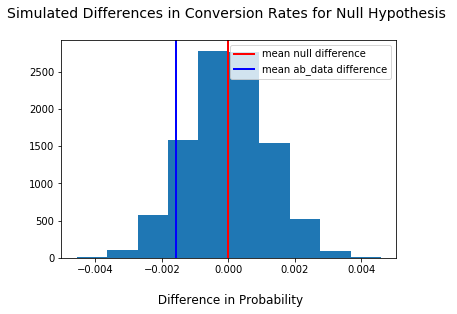

In [31]:
p_diffs = np.asarray(p_diffs)
plt.hist(p_diffs);
plt.title("Simulated Differences in Conversion Rates for Null Hypothesis \n", fontsize=14)
plt.xlabel("\n Difference in Probability", fontsize=12)
plt.axvline(x, color='r', linewidth=2, label='mean null difference')
plt.axvline(y, color='b', linewidth=2, label='mean ab_data difference')
plt.legend()

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
(p_diffs > y).mean()

0.9039

**The portion of p_diffs that is greater than the perceived difference in the original dataset is know as p-value. In this case the p-value is 0.91 which is far more higher than the normal $\alpha$ value of 0.05. A value of 0.05 indicates that we have a 5% chance of making a Type 1 error if the null is true. So a p-value is the probability that your statistic is observed although the null is true. In this case we said with the null that there is no difference in converting users depending on the type of landing page. As our p-value is really high we do not have enough or actually no evidence to rejust our null-hypothesis**

In [33]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1')['converted'].count()
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].count()
n_old = numControl
n_new = numTreatment

Use `stats.proportions_ztest` to compute your test statistic and p-value.

In [34]:
z, p = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z, p

(1.3109241984234394, 0.9050583127590245)

**The conversion rate of the new landing page has a distance from 1.31 standard deviations from the conversion rate of the old landing page which indicates that the value is to small to reject the null hypothesis. Also, the p-value is 0.91. So the findings agree with the findings in the part before**

<a id='regression'></a>
### Part III - A logistic regression approach


The goal is to use **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives.

In [35]:
df2['intercept'] = 1

df2[['landing_page_new', 'landing_page_old']] = pd.get_dummies(df2['landing_page'])
df2[['ab_page_control','ab_page_treatment']] = pd.get_dummies(df2['group'])

df2.drop(['landing_page_old','ab_page_control'], axis=1, inplace=True)

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,landing_page_new,ab_page_treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0


Use **statsmodels** to instantiate the regression model on the two columns, then fit the model using the two columns to predict whether or not an individual converts. 

In [36]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page_treatment']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Summary of the model below:

In [37]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
===================================================================
Model:               Logit            Pseudo R-squared: 0.000      
Dependent Variable:  converted        AIC:              212780.3502
Date:                2021-04-15 15:55 BIC:              212801.5095
No. Observations:    290584           Log-Likelihood:   -1.0639e+05
Df Model:            1                LL-Null:          -1.0639e+05
Df Residuals:        290582           LLR p-value:      0.18988    
Converged:           1.0000           Scale:            1.0000     
No. Iterations:      6.0000                                        
-------------------------------------------------------------------
                   Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
intercept         -1.9888   0.0081 -246.6690 0.0000 -2.0046 -1.9730
ab_page_treatment -0.0150   0.0114   -1.3109 0.1899 -0.0374  0.0074
===================================================================

"""

**The p-value associated with ab_page is 0.1899. It differs because we set different hypothesis. In this part we said the null is that there is no difference between the conversion rate of the old and new landing page. The alternative was: The difference between new and old is greater or less then 0 (two tailed test).**

**It is a good idea to add more factors into our regression model if we have more available data. It turns out that we can add the country variable to the model to see if there is a difference in converting users based on countries.**

Does it appear that country had an impact on conversion? 

In [38]:
df_c = pd.read_csv('countries.csv')
df_c.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [39]:
c_dummies = pd.get_dummies(df_c['country'])
dfnew = df_c.join(c_dummies)
dfnew.head()

,user_id,country,CA,UK,US
0,834778,UK,0,1,0
1,928468,US,0,0,1
2,822059,UK,0,1,0
3,711597,UK,0,1,0
4,710616,UK,0,1,0


In [40]:
df_all = df2.set_index('user_id').join(dfnew.set_index('user_id'))
df_all['intercept']=1
df_all.head()

,timestamp,group,landing_page,converted,intercept,landing_page_new,ab_page_treatment,country,CA,UK,US
user_id,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,US,0,0,1


In [41]:
logit_mod = sm.Logit(df_all['converted'], df_all[['intercept', 'UK', 'US']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2021-04-15 15:55 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

**The correlation coefficent is < 0.1 and therefore small for both UK and US with CA as baseline. That leads me to the confirmation that here is no significant relationship between country and conversion.**

Summary results and conclusions based on the results.

In [42]:

df_all['UK_ab_page'] = df_all['UK'] * df_all['ab_page_treatment']
df_all['US_ab_page'] = df_all['US'] * df_all['ab_page_treatment']

In [43]:
lm = sm.Logit(df_all['converted'], df_all[['intercept', 'ab_page_treatment', 'UK', 'UK_ab_page' ,'US', 'US_ab_page']])
results = lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-04-15 15:55 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept         -2.0040   0.0364 -55.0077 0.0000 -2.0754 -1.9326
ab_page_treatment -0.0674   0.0520  -1.2967 0.1947 -0.1694  0.0345
UK                 0.0118   0.0398   0.2957 0.7674 -0.0663  0.0899
UK_ab_page         0.0783   0.0568   1.3783 0.1681 -0.0330  0.1896
US                 0.0175   0.0377   0.4652 0.6418 -0.0563  0.0914
US_ab_page         0.0469   0.0538   0.8718 0.3833 -0.0585  0.1523
==================================================================

"""

**The p-value remains higher than the 0.05 threshold we normally use, so there is no evidence to reject the null hypothesis and countries have no significant influence on the conversion.**

<a id='conclusions'></a>
## Conclusions

Statiscally spoken there is no evidence for the new landing page to contribute to a higher conversion rate. As we showed before, with p-value higher than 0.05 we have no reason to reject the null hypothesis and therefore we have to assume that the old landing page does the same job in terms of conversion rate. Practically this means the company should not roll out the new landing page as their home landing page. With a high sample size like in this case there is enough testing done. Also there is no indicator that the country influences the conversion of the landing page. With this said, the company should focus on developing a new landing page as further tests with this two landing page versions and a higher sample size wont bring new conclusions. Also the company could focus on additional information to include for further testing as perhaps other characteristics like time of use could bring more information about why the new landing page did not work and what to improve in the future

